
#### CNN_LSTM - ConvLSTM2D

#### Image Classification using CNN. As you all know that CNN works great on the images, but a video has an extra dimension, which is Time.

#### basically videos are nothing but a series of images over time, which makes a video classification problem, a sequence classification task. And when it comes to sequences related problem, LSTM is the first thing which comes in our mind.

### ConvLSTM is a variation of LSTM cell that performs convolution within the LSTM cell. It replaces the matrix multiplication with the convolution operation. By applying convolution it captures the spatial features from the image.

In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
import tensorflow as tf
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model
 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
## pip install keras-metrics
import keras_metrics as km
 
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix


C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\jaghos\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:
data_dir = "C:/1-GG/CAP4/EventDetection/Dataset-LSTM/VDO/"
os.listdir(data_dir)


['Basketball', 'SoccerPenalty']

In [3]:

img_height , img_width = 64, 64
seq_len = 30
classes = ["Basketball", "SoccerPenalty"]


In [4]:

 
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = image / 255
            frames_list.append(normalized_frame)
            count += 1
            
        else:
            print("Defected frame")
            break
 
            
    return frames_list
 
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
           frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
           if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 


In [5]:
X, Y = create_data(data_dir)

Basketball
SoccerPenalty


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

In [7]:
X_train.shape

(228, 30, 64, 64, 3)

In [8]:
X_test.shape

(57, 30, 64, 64, 3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 30, 62, 62, 64)    154624    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 62, 62, 64)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 30, 60, 60, 32)    110720    
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 58, 58, 16)        27712     
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13779200  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

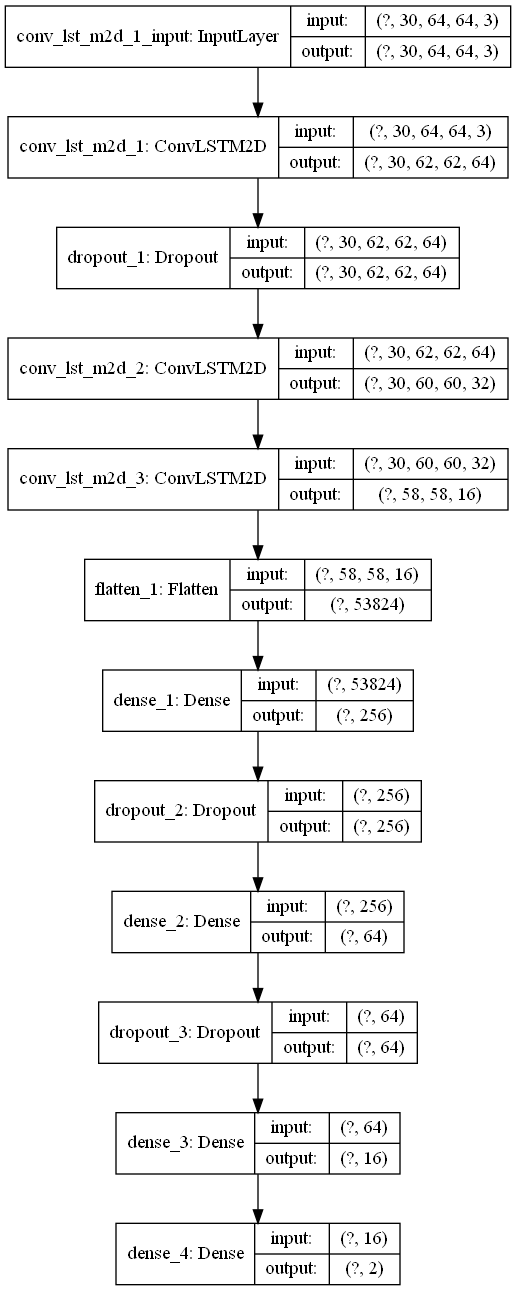

In [9]:

model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = True, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = True, data_format = "channels_last"))#return sequences should be true so that the next convlstm layer can get the right input shape of sequences
model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
#model.add(Dense(6, activation = "softmax"))
model.add(Dense(2, activation = "softmax"))
 
print(model.summary())
 
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
 
## Check Model architecture
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [10]:
%%time
history = model.fit(x = X_train, y = y_train, epochs=10, batch_size = 4 , shuffle=True, validation_split=0.2, callbacks=callbacks)
 


Train on 182 samples, validate on 46 samples
Epoch 1/10
182/182 [==============================] - 80s 440ms/step - loss: 0.6598 - accuracy: 0.6978 - val_loss: 0.6201 - val_accuracy: 0.8261
Epoch 2/10
182/182 [==============================] - 80s 438ms/step - loss: 0.5527 - accuracy: 0.8022 - val_loss: 0.4675 - val_accuracy: 0.8913
Epoch 3/10
182/182 [==============================] - 77s 424ms/step - loss: 0.4307 - accuracy: 0.8462 - val_loss: 0.3574 - val_accuracy: 0.8478
Epoch 4/10
182/182 [==============================] - 74s 409ms/step - loss: 0.3154 - accuracy: 0.9176 - val_loss: 0.2240 - val_accuracy: 0.9348
Epoch 5/10
182/182 [==============================] - 79s 436ms/step - loss: 0.2327 - accuracy: 0.9286 - val_loss: 0.1482 - val_accuracy: 0.8913
Epoch 6/10
182/182 [==============================] - 80s 438ms/step - loss: 0.1612 - accuracy: 0.9451 - val_loss: 0.1558 - val_accuracy: 0.9348
Epoch 7/10
182/182 [==============================] - 78s 430ms/step - loss: 0.1413 -

In [11]:
import matplotlib.pyplot as plt
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

<Figure size 3000x3000 with 0 Axes>

In [12]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = history.history[metric_name_1]
  metric_value_2 = history.history[metric_name_2]


  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

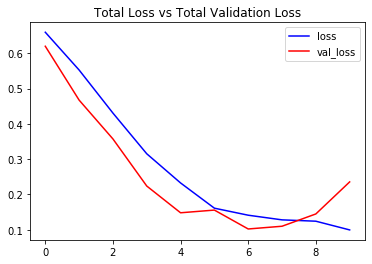

In [13]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

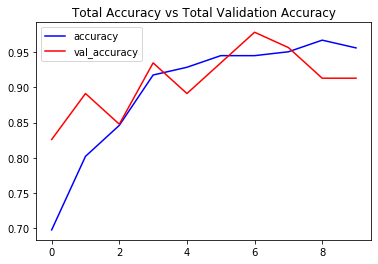

In [14]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [15]:
#model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = 'CNNLSTM_modelBP.h5'
## Where to save
modesavedFolder = "C:/1-GG/CAP4/EventDetection/Dataset-LSTM/SavedModel"

In [16]:
# Saving Model
model.save(modesavedFolder+'/'+model_name)

In [17]:
### How to readback the model from disk
from tensorflow import keras
model = keras.models.load_model(modesavedFolder+'/'+model_name)

In [18]:
%%time
with tf.device("cpu:0"):preds = model.predict(X_test,0)
preds = np.round(preds)

Wall time: 1min 7s


In [19]:
print('Round Test_labels' , preds)

Round Test_labels [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [20]:
from sklearn.metrics import classification_report
classification_metrics = classification_report(y_test,preds, target_names = classes)
print(classification_metrics)

               precision    recall  f1-score   support

   Basketball       0.86      1.00      0.93        25
SoccerPenalty       1.00      0.88      0.93        32

    micro avg       0.93      0.93      0.93        57
    macro avg       0.93      0.94      0.93        57
 weighted avg       0.94      0.93      0.93        57
  samples avg       0.93      0.93      0.93        57



# Test Model on Video

In [21]:
from collections import deque

Vdo_input_directory = 'C:/1-GG/CAP4/EventDetection/Dataset-LSTM/CNNLSTM_Apply_vdo/Apply_vdo'

# Getting input Video's path 
video_title = 'combined_video-2vdo'
input_video_file_path = f'{Vdo_input_directory}/{video_title}.mp4'
print(input_video_file_path)

C:/1-GG/CAP4/EventDetection/Dataset-LSTM/CNNLSTM_Apply_vdo/Apply_vdo/combined_video-2vdo.mp4


In [22]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

Vdo_output_directory = 'C:/1-GG/CAP4/EventDetection/Dataset-LSTM/CNNLSTM_Apply_vdo/OutPut_vdo'
# Setting up Output Video Path
output_video_file_path = f'{Vdo_output_directory}/{video_title} -Output-WSize {window_size}.mp4'

print(output_video_file_path)

C:/1-GG/CAP4/EventDetection/Dataset-LSTM/CNNLSTM_Apply_vdo/OutPut_vdo/combined_video-2vdo -Output-WSize 1.mp4


In [23]:
video_file_path = input_video_file_path

video_reader = cv2.VideoCapture(video_file_path)

if not video_reader.isOpened():
    print("Cannot open file")
else:
    print("Open successfully")
    


Open successfully


### Define Live VDO prediction function

In [24]:

 
#  Creating final output video
 
def Create_output_Video(video_path,output_file_path):
    frames_list = []
    frame_sequence = []
    original_frames = []
    vidObj = cv2.VideoCapture(video_path)
     # Getting the width and height of the video 
    original_video_width = int(vidObj.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(vidObj.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    # Used as counter variable 
    count = 1
 
    while True: 
         
        success, image = vidObj.read() 
        if success:
            original_frames.append(image)
            normalized_frame = cv2.resize(image, (img_height, img_width))
            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = normalized_frame / 255
            frames_list.append(normalized_frame)
            if(count % seq_len == 0):
                frame_sequence.append(frames_list)
                frame_sequence = np.array(frame_sequence)
                print(frame_sequence.shape)
                predicted_labels_probabilities = model.predict(frame_sequence, 0)
                predicted_labels_probabilities = np.round(predicted_labels_probabilities)
                predicted_label = np.argmax(predicted_labels_probabilities)
                predicted_class_name = classes[predicted_label]
                for original_frame in original_frames:
                    # Overlaying Class Name Text Ontop of the Frame
                    cv2.putText(original_frame, predicted_class_name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    #cv2.putText(frame, avg_prob, (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                    #cv2.putText(original_frame, predicted_labels_probabilities, (80, 100),  cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 0, 255), 2)
                    # Writing The Frame
                    video_writer.write(original_frame)
                frames_list = []
                frame_sequence = []
                original_frames = []
            count += 1
            
            
        else:
            print("Defected frame")
            break
            
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()
 

In [25]:
%%time
# Calling the create_output_video method to start the Prediction.
Create_output_Video(input_video_file_path,output_video_file_path)
print("Predicted Video Created")

(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 